### Autoregressive RNN with Softmax on Alanine Dipeptide

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

### Important Helper Functions

In [23]:
def flatten_data(data):
    """
    Input: data is a single dictionary item. In this case, for dialanine, it is a dictionary item 
    with six keys, each referencing a torch.tensor of size [256, 256, 256, (256, 19),(256, 19), (256, 19)]
    respectively. The batch size is 256, so the batch data is size [256, 256, 256, (256, 19), (256, 19), 
    (256, 19)]. Each dialiene molecule is  size [1, 1, 1, 19, 19, 19].
    
    Output: the dictionary item flattened into a 1-D tensor. It is a 1-D tensor of size 60
    for dialanine. We want a length 256 data object where each item is a 60-length 1-d tensor
    The resulting data object has shape: torch.Size of [256, 60].
    """
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result

def extract_ramachandran(data):
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result[:, [43,45]]

def rebuild(flat, data_length = 19):
    """
    Input: flattened tensor of torch.Size [256, 60], rebuild and return
    the original molecule, a dictionary item. The inverse of the flatten_data function.
    """
    data_length = 19 #this is particular to dialene
    result = {}

    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

def number_to_vec(ic, num_decimals = 2):
    """
    [1.80, 1.84, 0.97] -> [180, 184, 097]
    """
    ic = torch.trunc(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()
    num_of_classes = 2 * 3.14 * 10**num_decimals + 1
    one_hots = F.one_hot(indicies, num_classes = int(num_of_classes))

    return one_hots

def number_to_vec_class(ic, num_decimals = 2):
    ic = torch.trunc(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()

    return indicies

def index_to_number(ic, num_decimals = 2):
    ic = ic.float()
    return (ic-314)/100

def vec_to_number(one_hots, num_decimals = 2):
    labels_again = (torch.argmax(one_hots, dim=2) - 314)/100 #replace with dim=2 once u get it going
    return labels_again

### Calculate Means and Covariances of Bonds and Angles

In [24]:
## load required modules
## load MMCDataset class
## MMCD_path = "/path/to/MMCD"
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

ba_calculator = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

In [25]:
for batch_idx, (data, _) in enumerate(ba_calculator):
    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
    data = flatten_data(data)
    bonds_angles = data[:, :-19] 
    break

bonds_angles = bonds_angles.permute(1, 0)
npba = np.array(bonds_angles)
covmat = np.cov(npba)
means = np.mean(npba, axis = 1)
tr_cov = torch.tensor(covmat).double()
tr_means = torch.tensor(means).double()
bonds_angles_dist = dist.MultivariateNormal(loc = tr_means, covariance_matrix = tr_cov)


In [26]:
ba_distribution = bonds_angles_dist.sample(torch.tensor([256]))

In [15]:
ba_distribution.size()

torch.Size([256, 41])

In [27]:
## load required modules
## load MMCDataset class
## MMCD_path = "/path/to/MMCD"
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

In [34]:
class InternalCoordinateSoftmaxJordanRNNv2(nn.Module):
    def __init__(self, pre_bonds_angles_dist, batch_size = 256):
        super(InternalCoordinateSoftmaxJordanRNNv2, self).__init__()
        
        self.batch_size = 256
        self.hidden_size = 10
        self.steps = 19
        self.ba_dist = bonds_angles_dist
        
        #Modules for everything that is not the first input.
        self.hidden_to_energy = nn.ModuleList([nn.Linear(10, 629) for index in range(20)]) #Energy
        self.energy_to_hidden = nn.ModuleList([nn.Linear(629, 10) for index in range(20)])
        self.x_to_hidden = nn.ModuleList([nn.Linear(1, 10) for index in range(20)])
        self.ba_to_hidden = nn.Linear(41, 10)

        self.activation_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, ba, dihedrals): 

        h = self.ba_to_hidden(ba).to(device) #[256, number_of_bins = 628, 1]
        h = torch.unsqueeze(h, dim = 2)

        energy = self.hidden_to_energy[0](h[:, :, 0]) #[256, 628, 1]
        energy = torch.unsqueeze(energy, dim = 2)

        for index in range(1, self.steps, 1): #Recall generating the 0th item, so generate 18 more items

            x_t = dihedrals[:, index-1:index] 
            energy_t_minus_1 = energy[:, :, index-1]  

            a = self.x_to_hidden[index](x_t.float()) 
            b = torch.relu( self.energy_to_hidden[index](energy_t_minus_1)) #this index!!!

            new_h = torch.relu( a + b ) #size = [256, 10, 1]
            
            new_energy = self.hidden_to_energy[index](new_h)
            
            new_energy = torch.unsqueeze(new_energy, dim = 2)
            new_h = torch.unsqueeze(new_h, dim = 2)

            h = torch.cat([h, new_h], dim = 2)
            energy = torch.cat([energy, new_energy], dim = 2)

        return h, energy

    '''h = torch.zeros(X.size()[0], self.hidden_size, 1).to(device) #[256, number_of_bins = 628, 1]
        energy = self.hidden_to_energy[0](h[:, :, 0]) #[256, 628, 1]
        energy = torch.unsqueeze(energy, dim=2)

        categorical = self.activation_function(energy)
        temp_distribution = dist.Categorical(categorical)
        
        X = temp_distribution.sample()
        X = X.unsqueeze(dim = 1) #[num_samples, 1]
        #print(energy.size())'''

    
    def sample(self, num_samples = 256):
        ba = self.ba_dist.sample(torch.tensor([num_samples])).to(device).float()
        h = self.ba_to_hidden(ba).to(device) #[256, number_of_bins = 628, 1]
        h = torch.unsqueeze(h, dim = 2)
        
        energy = self.hidden_to_energy[0](h[:, :, 0])
        categorical = self.activation_function(energy)
        temp_distribution = dist.Categorical(categorical)
        X = temp_distribution.sample()
        X = X.unsqueeze(dim = 1) #[num_samples, 1]
        energy = energy.unsqueeze(dim = 2)
        #print(energy.size())

        for index in range(1, self.steps, 1): #Recall generating the 0th item, so generate 18 more items
            
            #print(index)
            x_t = X[:, index-1:index] 
            energy_t_minus_1 = energy[:, :, index-1]  

            a = self.x_to_hidden[index](x_t.float()) 
            b = torch.relu(self.energy_to_hidden[index](energy_t_minus_1))

            new_h = torch.relu( a + b ) #size = [256, 10, 1]
            new_energy = self.hidden_to_energy[index](new_h)

            print(new_energy.size())
            temp_categorical = self.activation_function(new_energy) 
            print(temp_categorical.size())
            temp_distribution = dist.Categorical(temp_categorical)
            new_x = temp_distribution.sample()
            #print(new_x.size())

            new_energy = torch.unsqueeze(new_energy, dim = 2)
            new_h = torch.unsqueeze(new_h, dim = 2)

            h = torch.cat([h, new_h], dim = 2)
            energy = torch.cat([energy, new_energy], dim = 2)
            X = torch.cat([X, new_x.unsqueeze(dim=1)], dim = 1)
        
        dihedrals = X

        return h, ba, dihedrals

    def loss(self, X, Y, tensor_form = False):
        #X is a categorical distribution and Y is the target (one hot encoding).
        #this one gave me AIDs to solve
        #https://discuss.pytorch.org/t/cross-entropy-loss-for-a-sequence-time-series-of-output/4309
        #X = [256, 628, 19]
        #Y = [256, 19]
        #Y = Y.permute(1, 0)
        #X = X.permute(2, 0, 1)

        #X = [19, 256, 628]
        #Y = [19, 256]

        #X = torch.flatten(X, start_dim=0, end_dim=1) 
        #Y = torch.flatten(Y)   

        #print(X.size())
        #print(Y.size())
        
        loss_value = self.loss_function(X, Y)
        return loss_value        

device = torch.device("cuda")
model = InternalCoordinateSoftmaxJordanRNNv2(pre_bonds_angles_dist = bonds_angles_dist).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)  #lr is step size, arbitrarily picked.
model.sample(10)

torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
torch.Size([10, 629])
torch.Size([10])
torch.Size([10, 629])
to

(tensor([[[-2.4145e-02,  0.0000e+00,  0.0000e+00,  ...,  3.7808e+02,
            1.5239e+02,  1.0390e+01],
          [ 5.9715e-01,  5.8051e+01,  0.0000e+00,  ...,  3.7235e+02,
            0.0000e+00,  4.7995e+01],
          [-6.7472e-01,  8.1258e+01,  0.0000e+00,  ...,  0.0000e+00,
            2.9297e+02,  3.4368e+02],
          ...,
          [ 7.9124e-01,  1.4153e+02,  0.0000e+00,  ...,  4.0012e+02,
            2.1387e+01,  6.9691e+01],
          [-1.5151e-01,  7.8626e+01,  1.1144e+01,  ...,  1.0799e+02,
            0.0000e+00,  6.2622e+01],
          [-6.3738e-01,  1.1079e+02,  0.0000e+00,  ...,  1.4298e+02,
            0.0000e+00,  1.0007e+01]],
 
         [[-6.3610e-02,  0.0000e+00,  0.0000e+00,  ...,  2.5112e+02,
            1.5239e+02,  1.4854e+01],
          [ 5.4600e-01,  1.7582e+02,  0.0000e+00,  ...,  2.3586e+02,
            0.0000e+00,  4.0867e+01],
          [-6.6741e-01,  2.4638e+02,  0.0000e+00,  ...,  0.0000e+00,
            2.9297e+02,  3.1281e+02],
          ...,
    

In [29]:
h, ba, dihedrals = model.sample(1000)

In [30]:
print(ba.size())
print(dihedrals.size())

torch.Size([1000, 41])
torch.Size([1000, 19])


### Training Loop

In [31]:
loss_over_time = []

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU

        data = flatten_data(data)
        data = data.to(device)

        bonds_angles = data[:, :-19]
        dihedrals = data[:, 41:]
        dihedrals = number_to_vec_class(dihedrals)
        
        true_target = dihedrals

        optimizer.zero_grad()

        #print(bonds_angles.size())
        #print(dihedrals.size())

        h, X_pred = model(bonds_angles, dihedrals) #h is the hidden layers, but it is useless

        loss = model.loss(X = X_pred, Y = true_target)
        loss.backward()

        fake_loss = model.loss(torch.rand_like(X_pred), Y = true_target)

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

                #len(train_loader) should be 625
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader)),  #hardcoded batch size
                fake_loss.item() / len(train_loader)
                )
        
            loss_over_time.append(loss.item()/len(train_loader) )

for epoch in range(0, 10, 1):
    train(epoch)

    '''
    sample =  model.sample(1000)
    sample = rebuild(sample)
    potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(sample)
    print(np.sum(potential_energy_q_theta)/1000)
    '''

Train Epoch: 0 [0/625 (0%)]	Loss: 0.336736 0.010378861236572265
Train Epoch: 0 [100/625 (16%)]	Loss: 0.186939 0.010377121734619141
Train Epoch: 0 [200/625 (32%)]	Loss: 0.097825 0.01036456069946289
Train Epoch: 0 [300/625 (48%)]	Loss: 0.053222 0.01038551254272461
Train Epoch: 0 [400/625 (64%)]	Loss: 0.029216 0.010362353515625
Train Epoch: 0 [500/625 (80%)]	Loss: 0.019003 0.010377025604248047
Train Epoch: 0 [600/625 (96%)]	Loss: 0.013112 0.010379583740234375
Train Epoch: 1 [0/625 (0%)]	Loss: 0.011856 0.010380621337890625
Train Epoch: 1 [100/625 (16%)]	Loss: 0.009587 0.010376887512207032
Train Epoch: 1 [200/625 (32%)]	Loss: 0.008722 0.010362457275390625
Train Epoch: 1 [300/625 (48%)]	Loss: 0.008070 0.01039218978881836
Train Epoch: 1 [400/625 (64%)]	Loss: 0.007825 0.010377803802490234
Train Epoch: 1 [500/625 (80%)]	Loss: 0.007489 0.010385455322265626
Train Epoch: 1 [600/625 (96%)]	Loss: 0.007449 0.01036603012084961
Train Epoch: 2 [0/625 (0%)]	Loss: 0.007492 0.010377922821044923
Train Epoch

KeyboardInterrupt: 

44


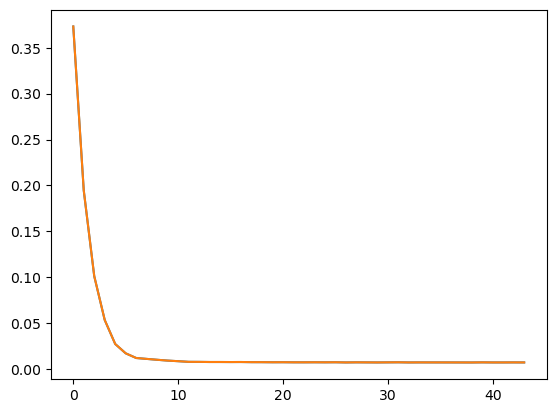

In [ ]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls)
plt.show()

### Sample From Model to View Distribtuions

In [ ]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 3000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = flatten_data(data)
    np_data = np.array(data)
    break

In [ ]:
hidden, ba, samples = model.sample(3000)

In [ ]:
samples = index_to_number(samples)

In [ ]:
np_samples = np.array(samples.cpu().detach())

In [35]:
ba = ba.cpu().numpy()

### Dihedrals

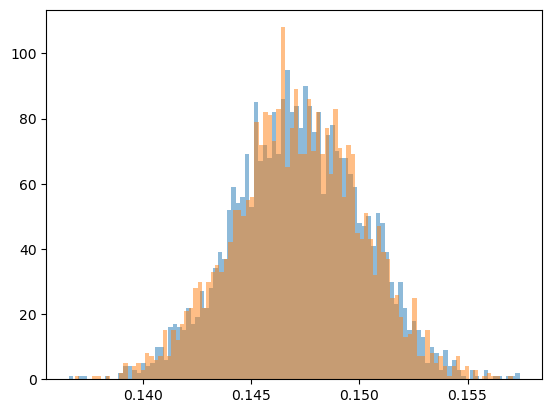

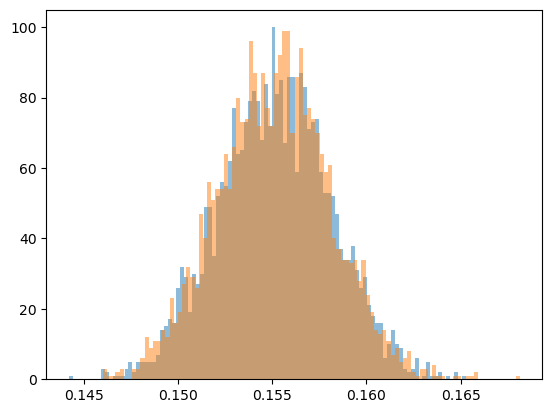

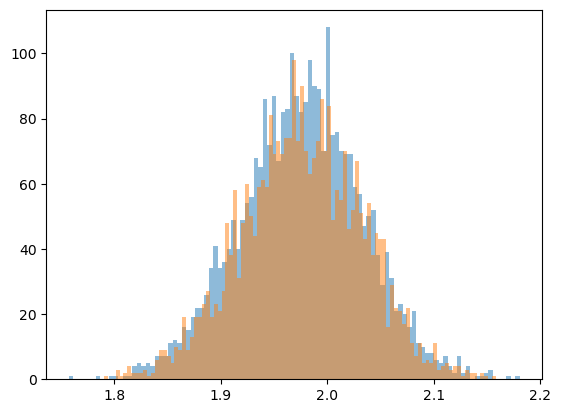

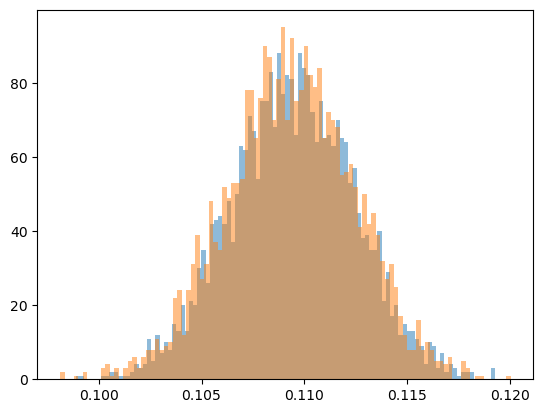

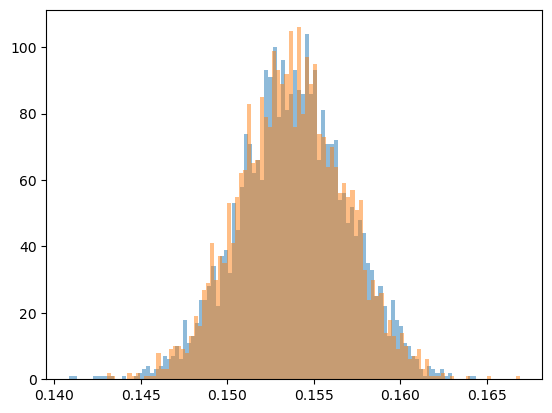

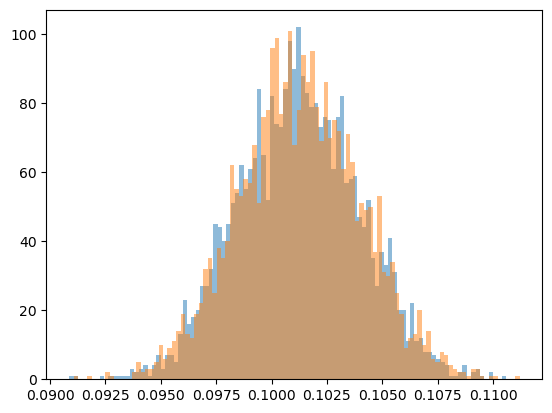

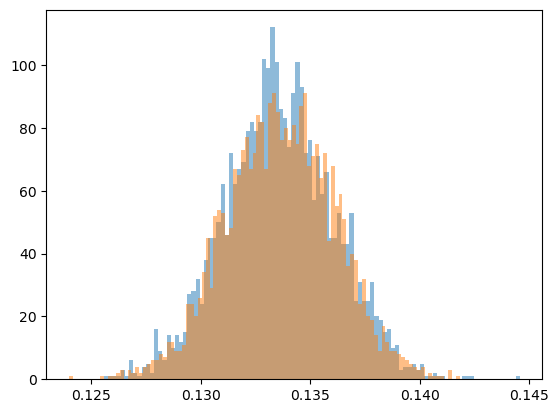

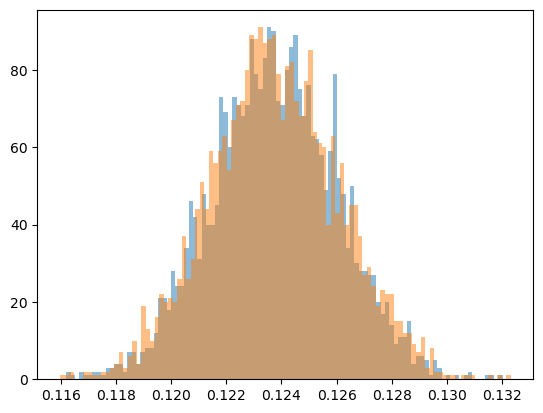

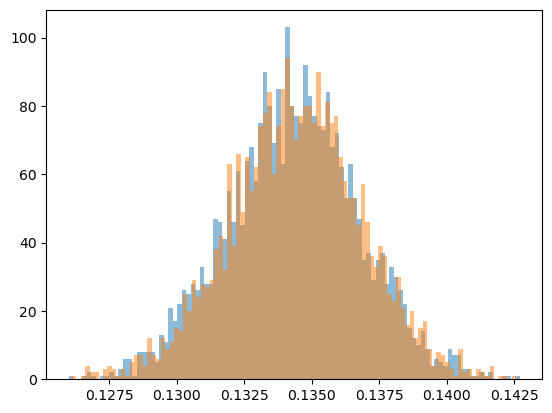

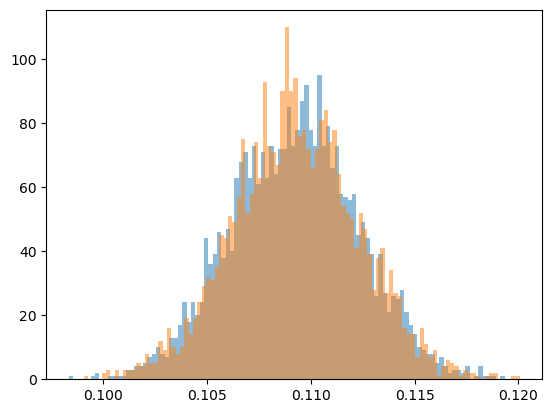

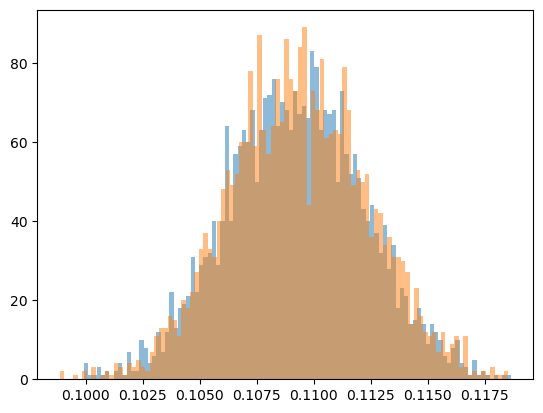

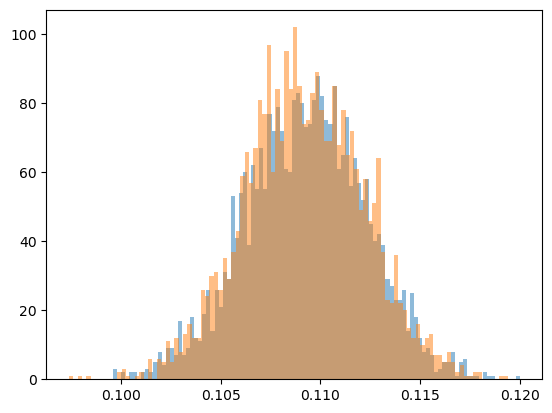

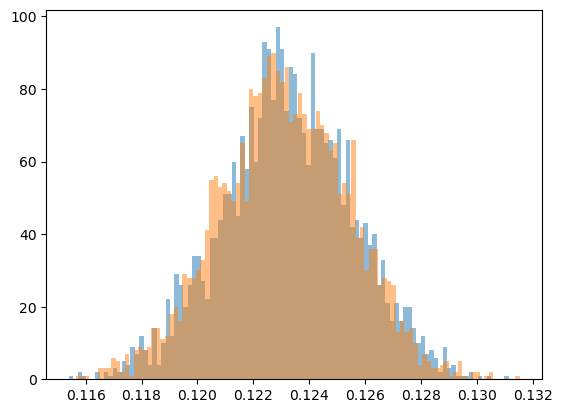

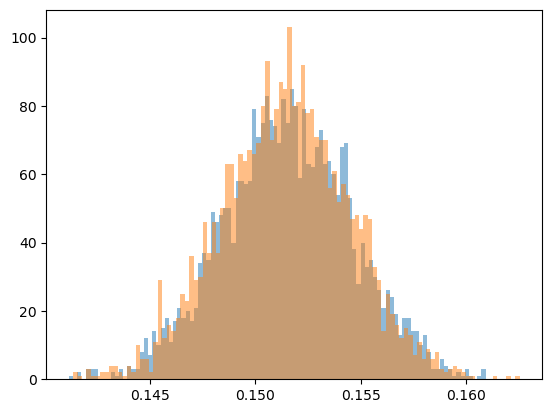

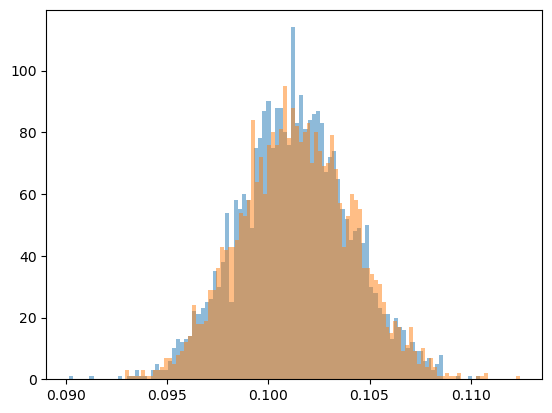

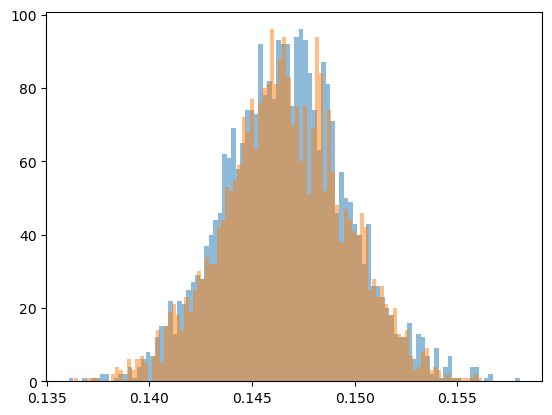

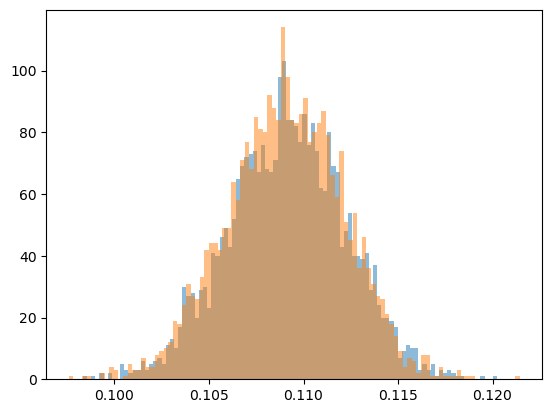

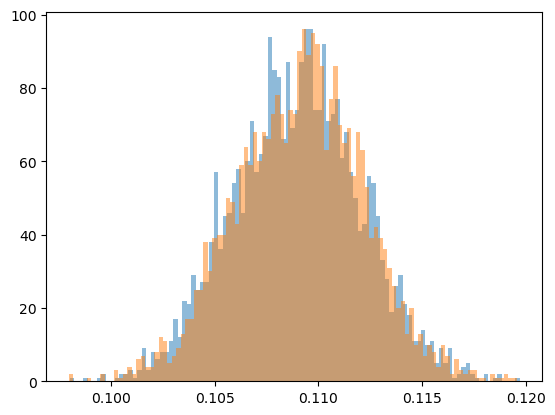

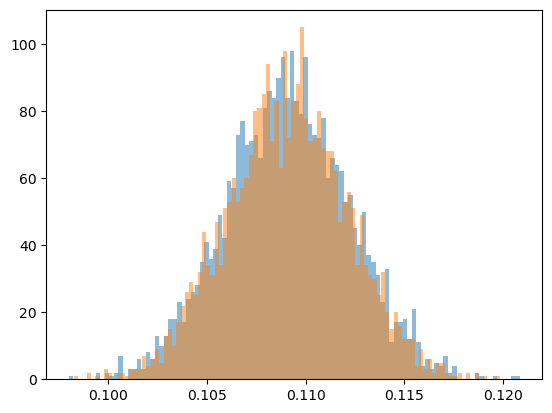

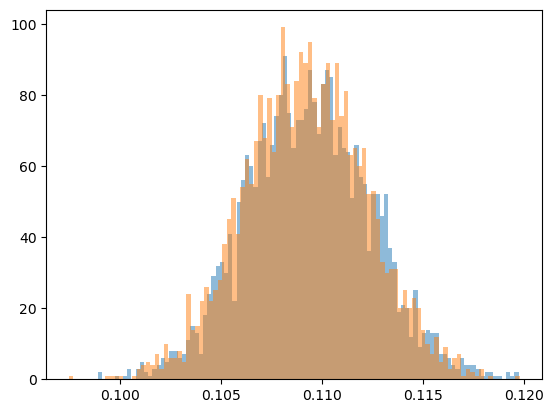

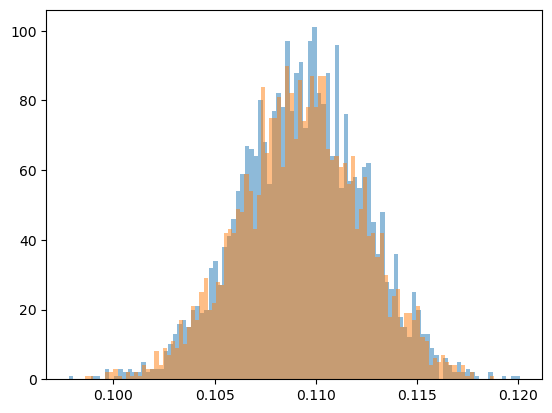

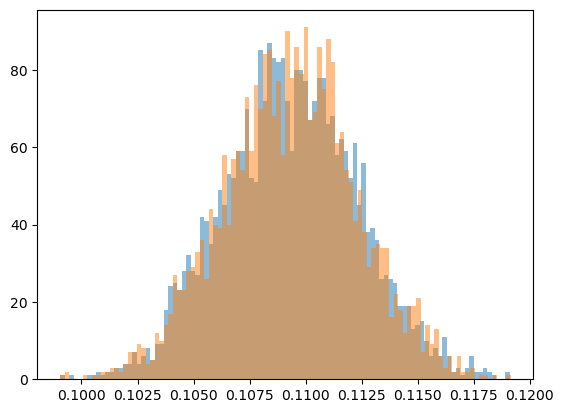

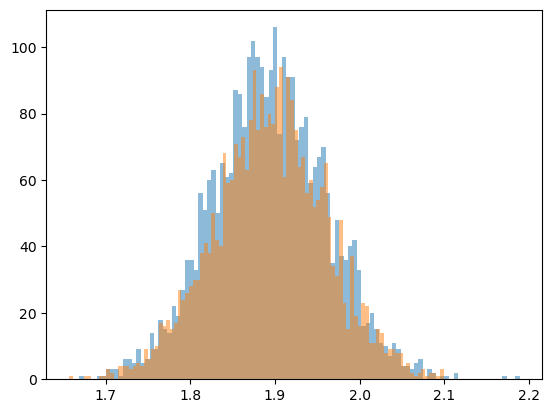

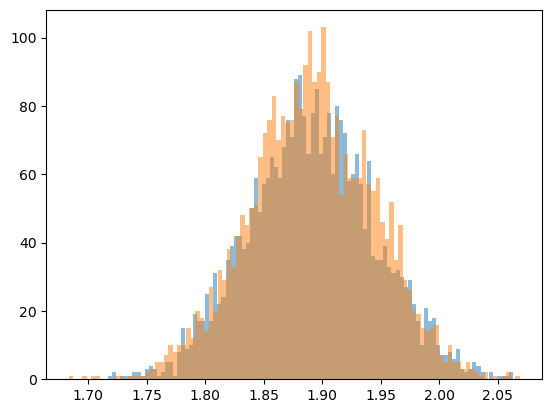

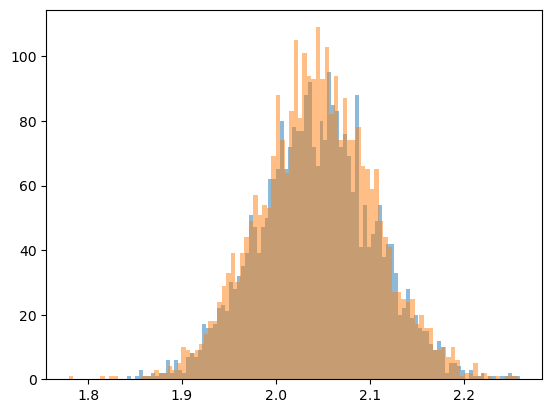

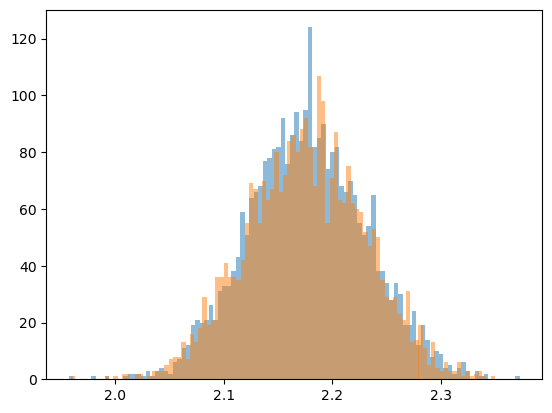

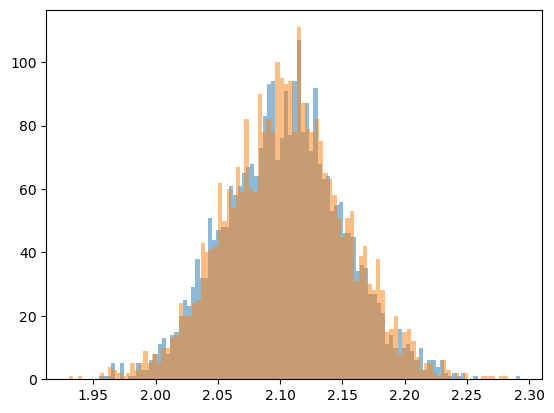

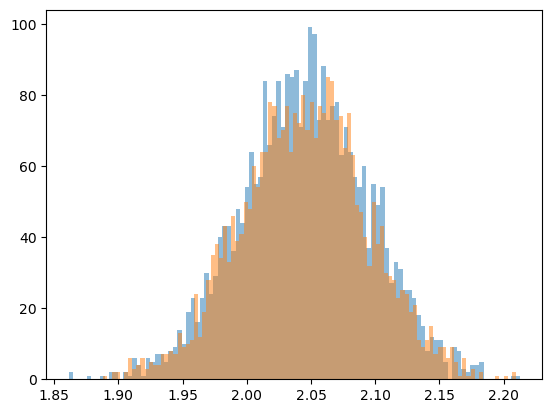

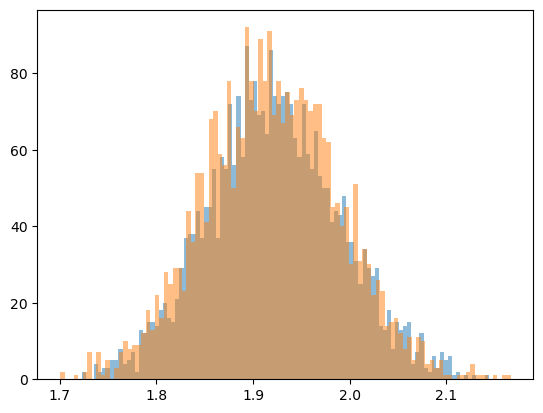

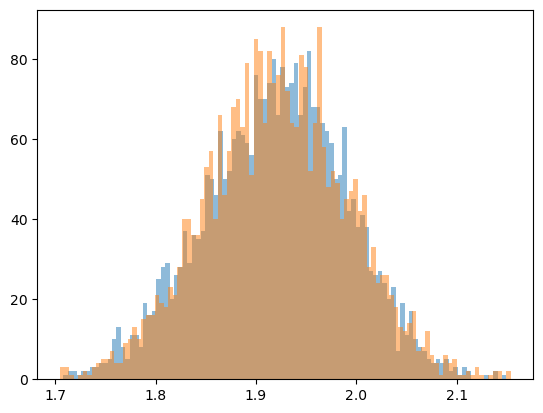

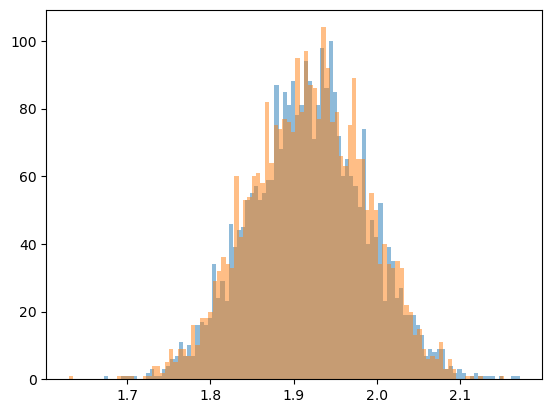

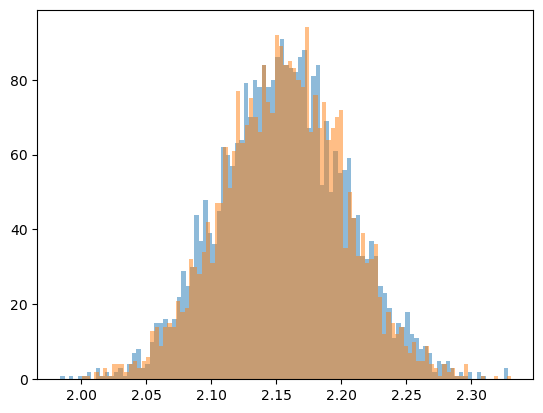

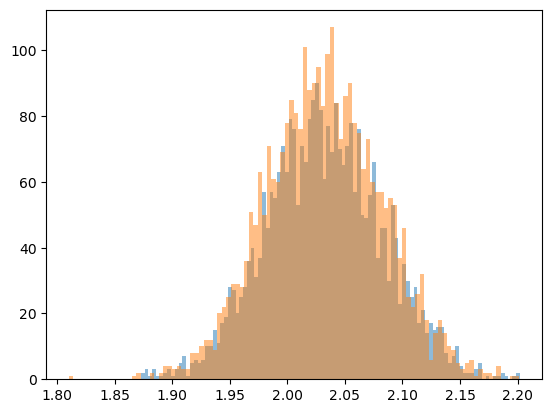

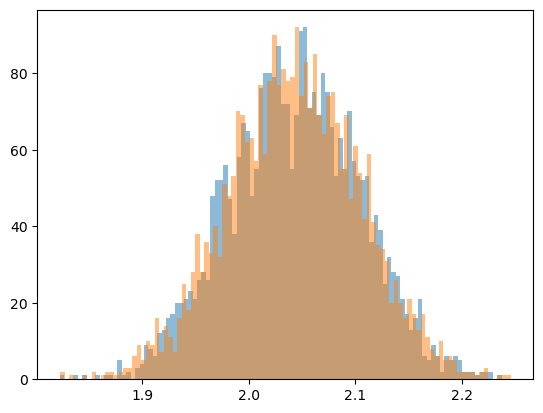

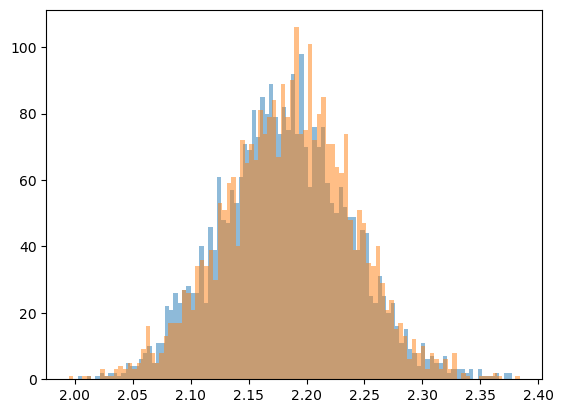

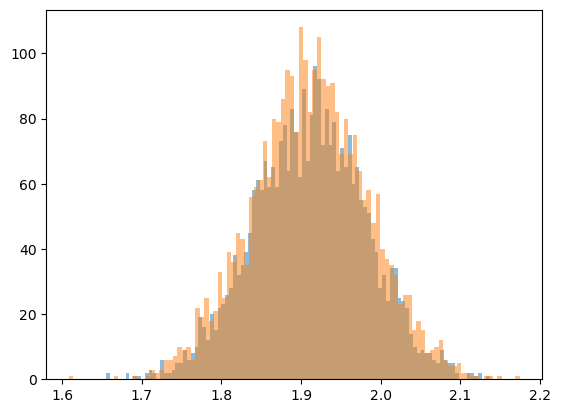

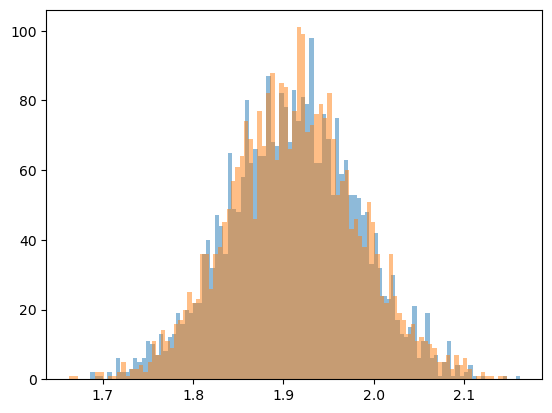

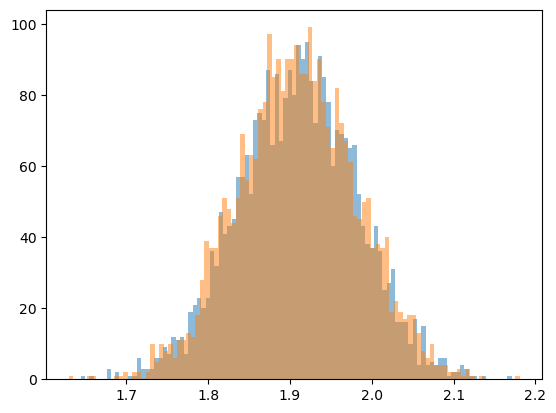

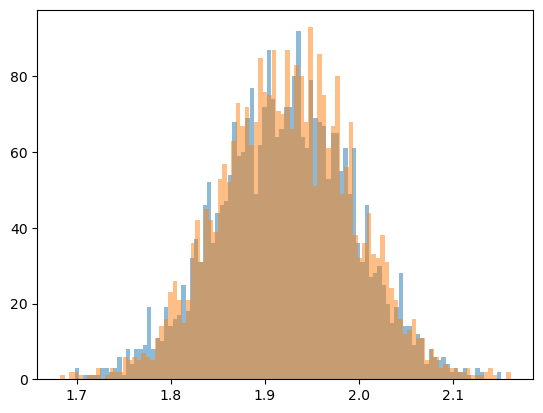

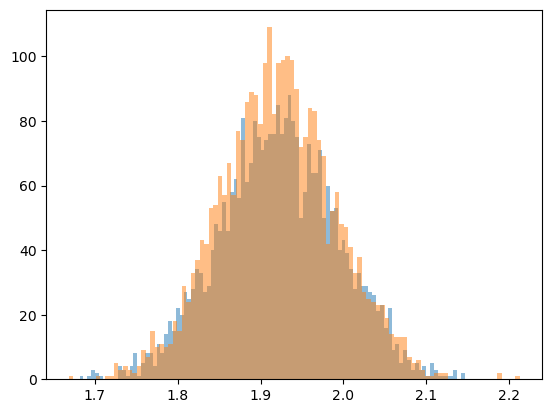

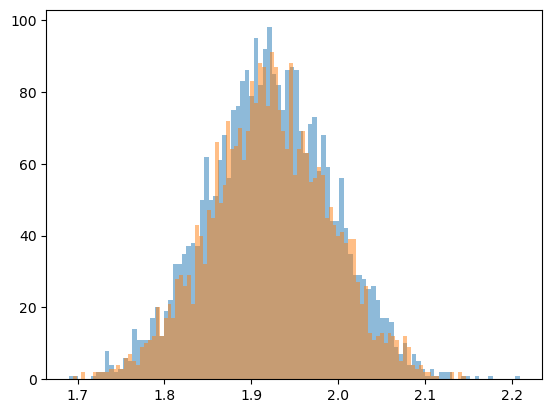

In [ ]:
'''for index in range(0, 41, 1):
    plt.hist(np_data[:, index], label = "$p_A(x)$",bins = 100, alpha = 0.5)
    plt.hist(ba[:, index], bins = 100, alpha=0.5)
    plt.show()'''

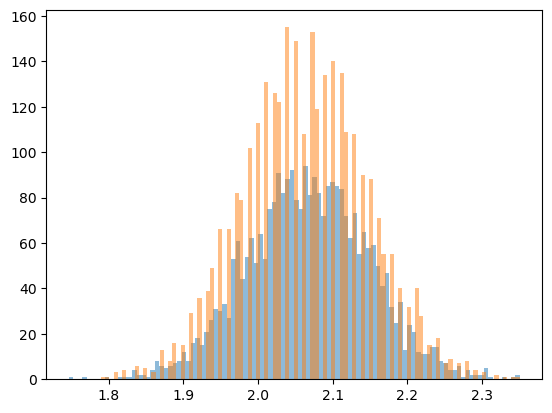

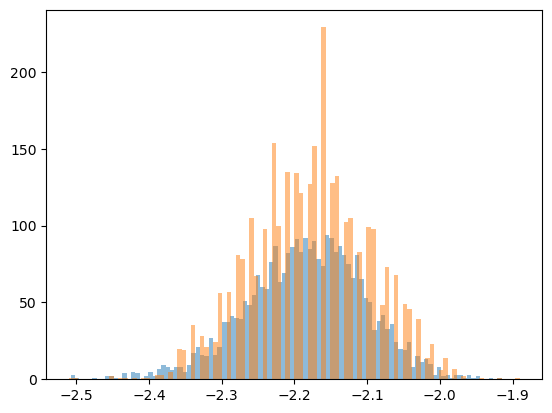

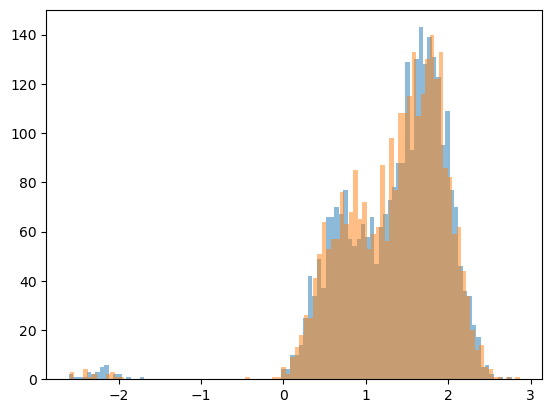

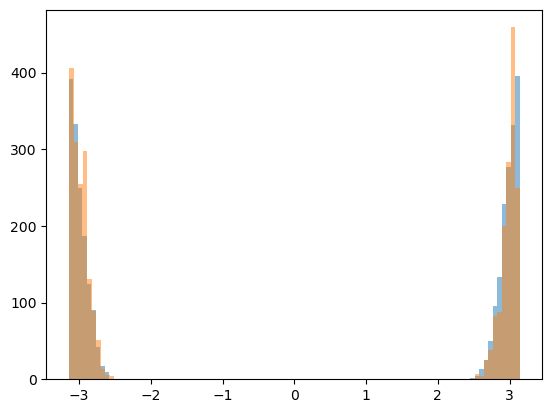

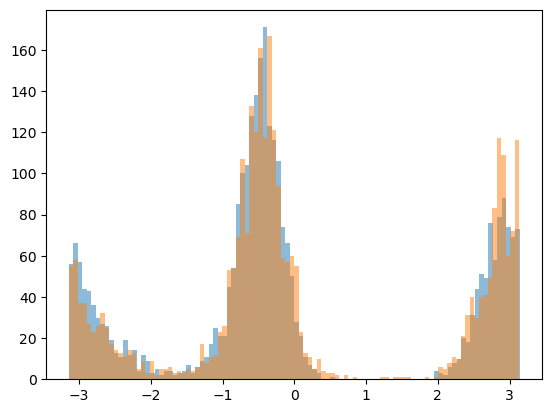

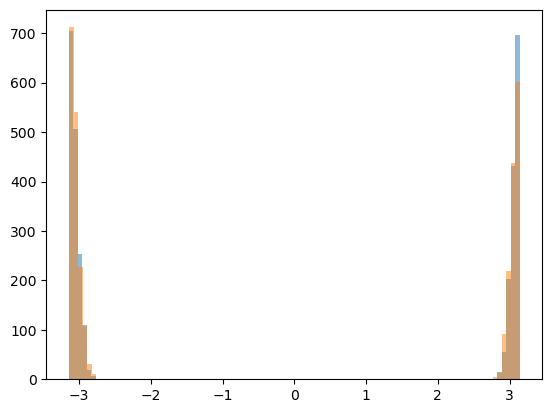

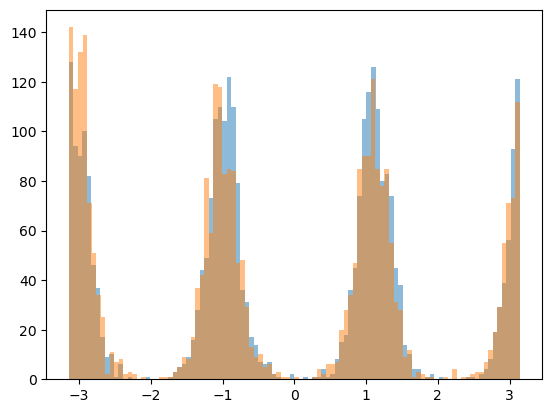

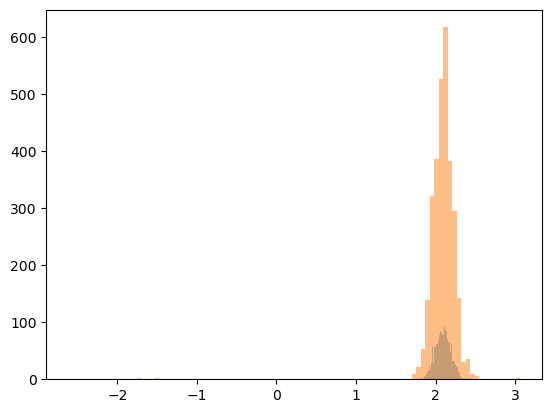

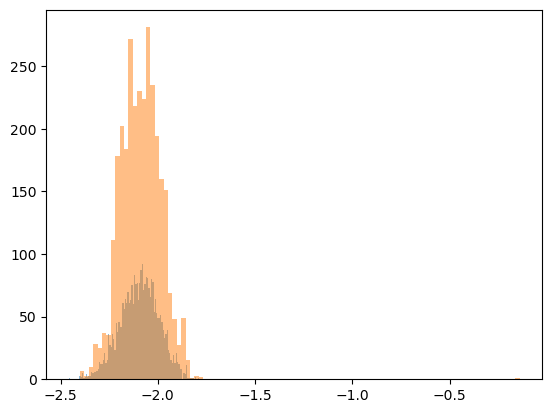

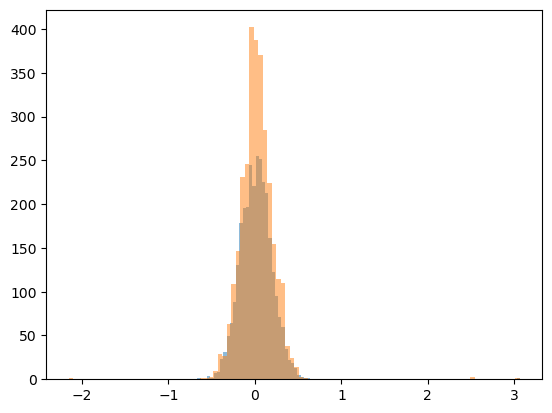

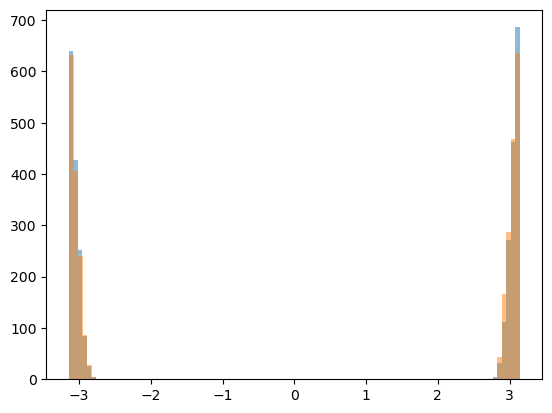

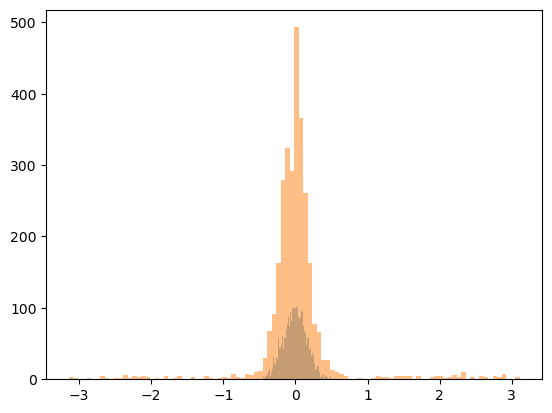

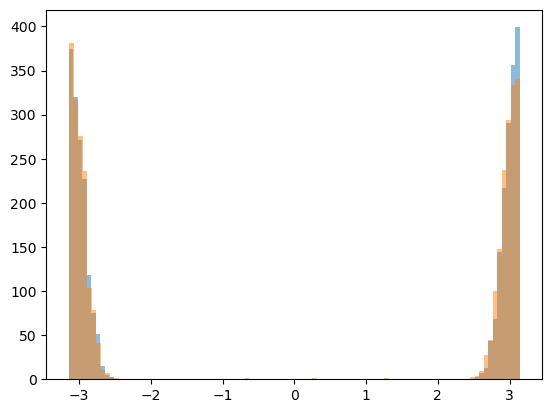

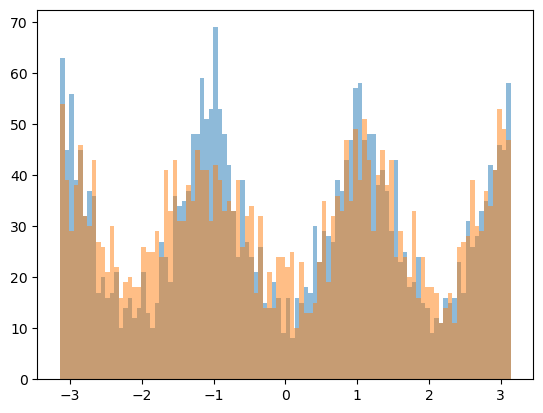

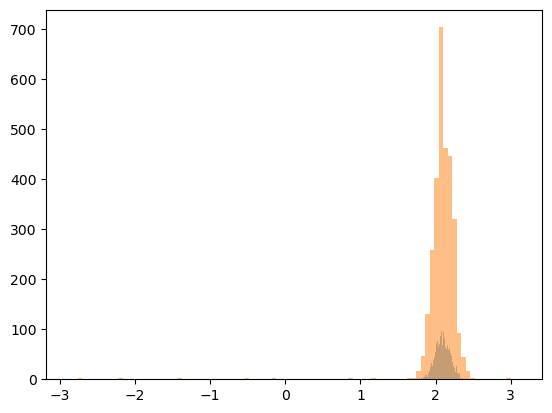

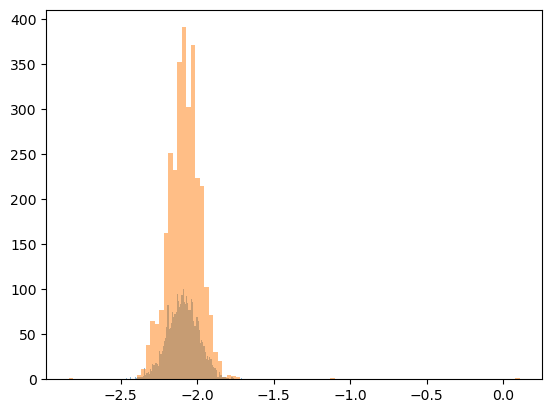

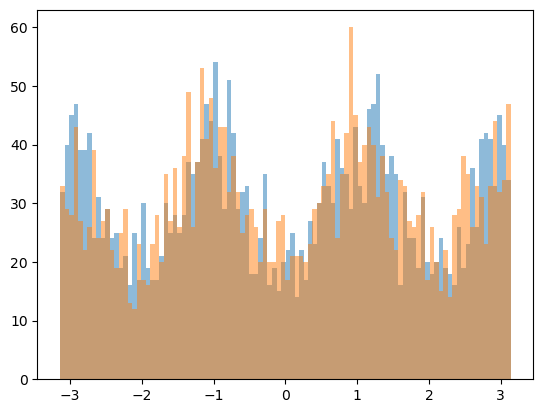

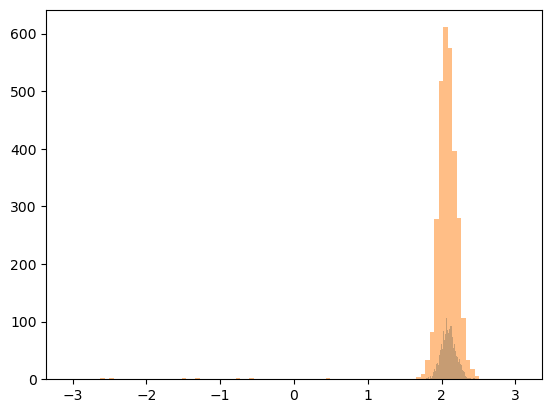

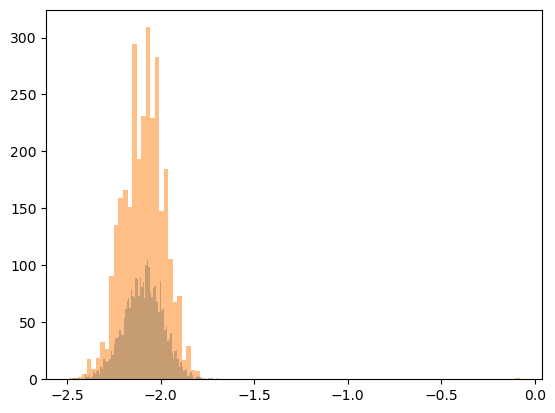

In [ ]:
for index in range(0, 19, 1):
    plt.hist(np_data[:, index+41], label = "$p_A(x)$",bins = 100, alpha = 0.5)
    plt.hist(np_samples[:, index], bins = 100, alpha=0.5)
    plt.show()

In [ ]:
'''for index in range(0, 60, 1):
    plt.hist(np_data[:, index], label = index,bins = 200, alpha = 0.5)
    #plt.hist(np_samples[:, index], bins = 100, alpha=0.5)
    plt.show()'''

'for index in range(0, 60, 1):\n    plt.hist(np_data[:, index], label = index,bins = 200, alpha = 0.5)\n    #plt.hist(np_samples[:, index], bins = 100, alpha=0.5)\n    plt.show()'

### Calculate Energies

In [ ]:
print(np.shape(np_samples))

(3000, 19)


In [ ]:
print(np.shape(ba))

(3000, 41)


In [ ]:
whole = np.concatenate((ba, np_samples), axis=1)

In [ ]:
print(np.shape(whole))

(3000, 60)


In [ ]:
molecules = rebuild(torch.tensor(whole))
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

In [ ]:
potential_energy_md = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [ ]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

dataloader_test = DataLoader(dataset_test,
                              num_workers = 8,
                              batch_size = 1280,
                              shuffle = False)

In [ ]:
p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [ ]:
print(np.shape(p_x[2]))

(200000,)


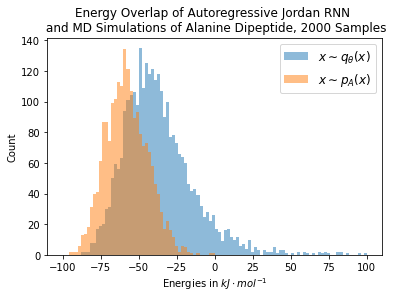

In [ ]:
plt.hist(potential_energy_q_theta, range =(-100, 100), bins = 100, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.hist(potential_energy_md[:2000], range =(-100, 100), bins = 100, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.title("Energy Overlap of Autoregressive Jordan RNN \n and MD Simulations of Alanine Dipeptide, 2000 Samples")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()